# Kaggle House Prices - Fit Random Forest Model

In [8]:
# Data
import pandas as pd
import numpy as np
import statistics
import re
import math
from scipy import stats

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.5, style="ticks")
fs = (14, 6) # make the figure wider than the default

# View all cols in jupyter notebook
from IPython.display import display
pd.options.display.max_columns = None

## Load and Transform the Data
* Load the data
* Fill 'NA's
* Correct data types

In [11]:
### Define a function to transform the data
def cleanme(houses):
    ## Rename columns starting with numbers
    col_names = [key for key in dict(houses.dtypes) if re.search("^[^A-Z]",key) != None]
    new_col_names = ['FirstFlrSF', 'SecondFlrSF', 'ThirdSsnPorch']
    new_col_names = dict(zip(col_names,new_col_names))
    houses.rename(columns=new_col_names, inplace=True)
    
    ## Override spurious NAs
    # PoolQu
    houses.PoolQC.fillna("NA", inplace=True)
    #MiscFeature
    houses.MiscFeature.fillna("NA", inplace=True)
    #Alley
    houses.Alley.fillna("NA", inplace=True)
    # Fence
    houses.Fence.fillna("NA", inplace=True)
    # FireplaceQu
    houses.FireplaceQu.fillna("NA", inplace=True)
    # Garages
    houses.GarageType.fillna("NA",inplace=True)
    houses.GarageFinish.fillna("NA",inplace=True)
    houses.GarageQual.fillna("NA",inplace=True)
    houses.GarageCond.fillna("NA",inplace=True)
    # Basements
    houses.BsmtExposure.fillna("NA",inplace=True)
    houses.BsmtFinType1.fillna("NA",inplace=True)
    houses.BsmtFinType2.fillna("NA",inplace=True)
    houses.BsmtQual.fillna("NA",inplace=True)
    houses.BsmtCond.fillna("NA",inplace=True)
    # Masonry
    houses.MasVnrType.fillna("NA",inplace=True)
    houses.MasVnrArea.fillna(0,inplace=True)
    # Lot Frontage
    houses.LotFrontage.fillna(0, inplace=True)

    ## Change some strings to ordinal values
    # ExterQual
    exterqual = {"Po" : 0, "Fa": 1, 'TA':2, 'Gd':3, 'Ex':4}
    houses.ExterQual = houses.ExterQual.apply(lambda v: exterqual[v])
    # ExterCond
    extercond = {"Po" : 0, "Fa": 1, 'TA':2, 'Gd':3, 'Ex':4}
    houses.ExterCond = houses.ExterCond.apply(lambda v: extercond[v])
    # BsmtQual
    basmtqual = {"NA":0, "Po" : 1, "Fa": 2, 'TA':3, 'Gd':4, 'Ex':5}
    houses.BsmtQual = houses.BsmtQual.apply(lambda v: basmtqual[v])
    # BsmtCond
    basmtcond = {"NA":0, "Po" : 1, "Fa": 2, 'TA':3, 'Gd':4, 'Ex':5}
    houses.BsmtCond = houses.BsmtCond.apply(lambda v: basmtcond[v])
    # BsmtExposure
    basmtexposure = {"NA" : 0, "No": 1, 'Mn':2, 'Av':3, 'Gd': 4}
    houses.BsmtExposure = houses.BsmtExposure.apply(lambda v: basmtexposure[v])
    # BsmtFinType_1
    bsmtfintype = {"NA":0, "Unf" : 1, "LwQ": 2, 'Rec':3, 'BLQ':4, 'ALQ':5, "GLQ": 6}
    houses.BsmtFinType1 = houses.BsmtFinType1.apply(lambda v: bsmtfintype[v])
    # KitchenQual
    kitqual = {'Fa':0,'TA':1,'Gd':2, 'Ex':3}
    houses.KitchenQual = houses.KitchenQual.apply(lambda v: kitqual[v])
    # Functional
    functional = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
    houses.Functional = houses.Functional.apply(lambda v: functional[v])
    # FireplaceQu
    fireplacequ = {'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
    houses.FireplaceQu = houses.FireplaceQu.apply(lambda v: fireplacequ[v])
    # GarageFinish
    garagefinish = {'NA':0,'Unf':1,'RFn':2,'Fin':3}
    houses.GarageFinish = houses.GarageFinish.apply(lambda v: garagefinish[v])
    
    ## Transform non-linear features
    # BsmtFinSF1
    x = houses.BsmtFinSF1.apply(lambda x: x + 1)
    houses.BsmtFinSF1,_ = stats.boxcox(x)
    

In [12]:
# Load the training data
houses = pd.read_csv("data/train.csv")
print(houses.shape)

# Clean it
cleanme(houses)

(1460, 81)


In [4]:
# What % data (if any) is missing for each column?
nulls = houses.isnull().sum()
nulls = pd.DataFrame(nulls)
nulls.rename(columns={0:"cnt_missing"},inplace=True)
nulls = nulls[nulls.cnt_missing>0]
nulls['pct_missing'] = round(nulls.cnt_missing/houses.shape[0] * 100,2)
nulls.sort_values(by="pct_missing",ascending=False)

,cnt_missing,pct_missing
GarageYrBlt,81,5.55
Electrical,1,0.07


In [5]:
# Drop the row missing the electrical data
houses = houses[houses.Electrical.isnull()==False]

In [6]:
houses.sample(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,FirstFlrSF,SecondFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ThirdSsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
133,134,20,RL,0.0,6853,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,136.0,3,2,PConc,5,3,1,6,1005,Unf,0,262,1267,GasA,Ex,Y,SBrkr,1296,0,0,1296,1,0,2,0,2,1,2,6,7,0,0,Attchd,2001.0,3,2,471,TA,TA,Y,192,25,0,0,0,0,NA,NA,NA,0,6,2009,WD,Normal,220000
862,863,20,RL,81.0,9672,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,SawyerW,Norm,Norm,1Fam,1Story,6,5,1984,1985,Hip,CompShg,HdBoard,Plywood,None,0.0,2,2,PConc,4,3,1,6,338,Unf,0,702,1040,GasA,TA,Y,SBrkr,1097,0,0,1097,0,0,2,0,3,1,1,6,7,0,0,Attchd,1986.0,1,2,480,TA,TA,Y,0,0,0,0,0,0,NA,GdPrv,NA,0,5,2010,WD,Normal,152000
300,301,190,RL,90.0,15750,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,2fmCon,1Story,5,5,1953,1953,Hip,CompShg,MetalSd,MetalSd,BrkFace,56.0,2,2,CBlock,3,3,2,4,841,Unf,0,324,1165,GasA,TA,Y,SBrkr,1336,0,0,1336,1,0,1,0,2,1,1,5,7,2,4,Attchd,1953.0,1,1,375,TA,TA,Y,0,0,0,0,0,0,NA,NA,NA,0,6,2006,WD,Normal,157000
466,467,20,RL,85.0,10628,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1970,1970,Flat,Tar&Grv,Plywood,Plywood,None,0.0,2,3,CBlock,3,4,4,6,778,Unf,0,499,1277,GasA,TA,Y,SBrkr,1277,0,0,1277,1,0,1,0,2,1,1,5,7,1,1,Attchd,1970.0,1,2,526,TA,TA,Y,0,0,0,0,176,0,NA,GdWo,NA,0,4,2007,WD,Normal,167000
719,720,20,RL,69.0,9920,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,5,6,1969,1969,Gable,CompShg,HdBoard,Plywood,None,0.0,2,2,CBlock,4,3,4,5,523,Unf,0,448,971,GasA,TA,Y,SBrkr,971,0,0,971,0,0,1,1,3,1,1,5,7,1,1,Attchd,1969.0,1,1,300,TA,TA,Y,0,0,0,0,0,0,NA,NA,NA,0,5,2006,WD,Normal,128500
29,30,30,RM,60.0,6324,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,BrkSide,Feedr,RRNn,1Fam,1Story,4,6,1927,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,2,2,BrkTil,3,3,1,1,0,Unf,0,520,520,GasA,Fa,N,SBrkr,520,0,0,520,0,0,1,0,1,1,0,4,7,0,0,Detchd,1920.0,1,1,240,Fa,TA,Y,49,0,87,0,0,0,NA,NA,NA,0,5,2008,WD,Normal,68500
1372,1373,60,RL,75.0,9750,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,2,2,PConc,4,3,3,6,975,Unf,0,133,1108,GasA,Ex,Y,SBrkr,1108,989,0,2097,1,0,2,1,3,1,2,8,7,1,3,Detchd,1998.0,2,2,583,TA,TA,Y,253,170,0,0,0,0,NA,NA,NA,0,6,2006,WD,Normal,274300
1196,1197,60,RL,58.0,14054,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,2,PConc,4,3,3,1,0,Unf,0,879,879,GasA,Ex,Y,SBrkr,879,984,0,1863,0,0,2,1,4,1,2,9,7,1,4,BuiltIn,2006.0,3,3,660,TA,TA,Y,100,17,0,0,0,0,NA,NA,NA,0,11,2006,New,Partial,219210
514,515,45,RL,55.0,10594,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,1.5Unf,5,5,1926,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,2,2,BrkTil,3,3,1,1,0,Unf,0,768,768,Grav,Fa,N,SBrkr,789,0,0,789,0,0,1,0,2,1,1,5,7,0,0,Detchd,1926.0,1,1,200,Po,Po,Y,0,0,112,0,0,0,NA,MnPrv,NA,0,6,2007,WD,Normal,96500
503,504,20,RL,100.0,15602,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,1Story,7,8,1959,1997,Gable,CompShg,BrkFace,Wd Sdng,None,0.0,2,2,CBlock,3,3,1,5,1247,Unf,0,254,1501,GasA,TA,Y,SBrkr,1801,0,0,1801,1,0,2,0,1,1,1,6,7,2,3,Attchd,1959.0,3,2,484,TA,TA,Y,0,54,0,0,161,0,NA,GdWo,NA,0,3,2010,WD,Normal,289000


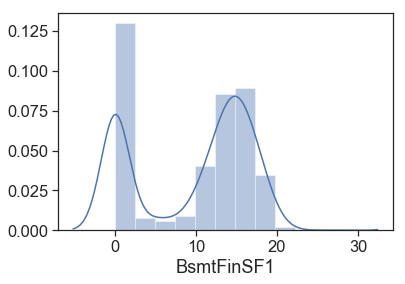

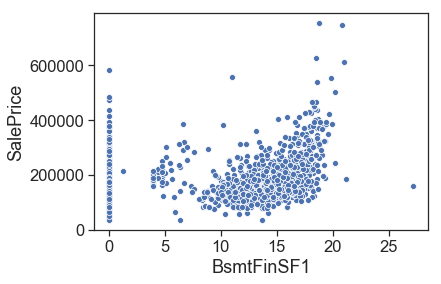

In [13]:
plt.figure()
sns.distplot(houses.BsmtFinSF1)
plt.figure()
sns.scatterplot(houses.BsmtFinSF1, houses.SalePrice)

## Explore Relationship between Vars and SalePrice

In [ ]:
# Look at data cols 41-60
my_cols = houses.iloc[:,41:61]
saleprice = houses['SalePrice']

In [ ]:
for i in range(0,my_cols.shape[1]):
    plt.figure(i)
    sns.scatterplot(x = my_cols.iloc[:,i], y = saleprice)

In [ ]:
# List columns with type object
# objs = houses.select_dtypes(include=['object']).dtypes
# objs = [re.sub(" *object","",s) for s in objs.index]
# objs

## Test using method from tutorial

https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd

### Create features (X) and labels (Y) series

In [ ]:
# FEATURES
# Create dummy cols when necessary - for the moment drop GarageYrBlt bc it contains nulls
features = pd.get_dummies(houses.drop('SalePrice',axis=1).drop('GarageYrBlt',axis=1).drop('Id',axis=1),
                          drop_first=True, dummy_na=True)
feature_list = list(features.columns) # Saving feature names for later use
features = np.array(features)         # Convert to numpy array

# LABELS (Response Variable)
labels = houses.SalePrice

### Create Training and Test Sets

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets (80:20)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2)

In [ ]:
# Is everything the right size so far?
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

### Train an Initial RF Model

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000)

# Train the model on training data
rf.fit(train_features, train_labels)

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

### Look at Feature Importances

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

In [ ]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000)
# Extract the most important features
important_indices = [feature_list.index('OverallQual'), feature_list.index('GrLivArea'),
                     feature_list.index('TotalBsmtSF'), feature_list.index('SecondFlrSF'),
                     feature_list.index('BsmtFinSF1'), feature_list.index('FirstFlrSF'),
                     feature_list.index('LotArea'), feature_list.index('GarageArea'),
                     feature_list.index('YearBuilt'), feature_list.index('YearRemodAdd'),
                     feature_list.index('GarageCars'),feature_list.index('BsmtQual'),
                     feature_list.index('KitchenQual'),feature_list.index('FullBath'),
                     feature_list.index('MasVnrArea'),feature_list.index('TotRmsAbvGrd'),
                     feature_list.index('WoodDeckSF')]

train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2))
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%')

In [ ]:
# Plot variable importances
x_values = []
y_values = []
for i in important_indices:
    x_values.append(feature_list[i])
    y_values.append(importances[i])
# Make a bar chart
plt.figure(figsize=fs)
plt.bar(x_values, y_values, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2, )
# Tick labels for x axis
plt.xticks(x_values, x_values, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')

## Cross Validation to Tune RF Parameters

In [ ]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# FEATURES
# Create dummy cols when necessary - for the moment drop GarageYrBlt bc it contains nulls
features = pd.get_dummies(houses.drop('SalePrice',axis=1).drop('GarageYrBlt',axis=1), drop_first=True, dummy_na=True)
feature_list = list(features.columns) # Saving feature names for later use
# features = np.array(features)         # Convert to numpy array

# LABELS (Response Variable)
labels = houses.SalePrice

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2)

In [ ]:
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestRegressor(n_estimators=100))

In [ ]:
# Declare hyperparameters to tune
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}

In [ ]:
clf = GridSearchCV(pipeline, hyperparameters, cv=10)
 
# Fit and tune model
clf.fit(train_features, train_labels)

In [ ]:
print(clf.best_params_)

In [ ]:
# Predict
labels_pred = clf.predict(test_features)

In [ ]:
print(r2_score(test_labels, labels_pred))
print(mean_squared_error(test_labels, labels_pred))

In [ ]:
# Make predictions and determine the error
errors = abs(labels_pred - test_labels)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2))
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%')

## Use params determined from CV to train on the entire training set

### Upload and clean test data

In [ ]:
# Load the test data
houses_test = pd.read_csv("data/cleaned_data/clean_test.csv")
houses_test.shape

In [ ]:
# Override spurious NAs
# PoolQu
houses_test.PoolQC.fillna("NA", inplace=True)

#MiscFeature
houses_test.MiscFeature.fillna("NA", inplace=True)

#Alley
houses_test.Alley.fillna("NA", inplace=True)

# Fence
houses_test.Fence.fillna("NA", inplace=True)

# FireplaceQu
houses_test.FireplaceQu.fillna("NA", inplace=True)

# Garages
houses_test.GarageType.fillna("NA",inplace=True)
houses_test.GarageFinish.fillna("NA",inplace=True)
houses_test.GarageQual.fillna("NA",inplace=True)
houses_test.GarageCond.fillna("NA",inplace=True)
houses_test.GarageCars.fillna(0, inplace=True)
houses_test.GarageArea.fillna(0, inplace=True)

# Basements
houses_test.BsmtExposure.fillna("NA",inplace=True)
houses_test.BsmtFinType1.fillna("NA",inplace=True)
houses_test.BsmtFinType2.fillna("NA",inplace=True)
houses_test.BsmtQual.fillna("NA",inplace=True)
houses_test.BsmtCond.fillna("NA",inplace=True)
houses_test.BsmtFullBath.fillna(0,inplace=True)
houses_test.BsmtFinSF1.fillna(0,inplace=True)
houses_test.BsmtFinSF2.fillna(0,inplace=True)
houses_test.BsmtUnfSF.fillna(0,inplace=True)
houses_test.BsmtHalfBath.fillna(0,inplace=True)
houses_test.TotalBsmtSF.fillna(0,inplace=True)

# Masonry
houses_test.MasVnrType.fillna("NA",inplace=True)
houses_test.MasVnrArea.fillna(0,inplace=True)

# KitchenQual
houses_test.KitchenQual.fillna("TA",inplace=True)

# Utilities
houses_test.Utilities.fillna("AllPub",inplace=True)

#Functional
houses_test.Functional.fillna("Typ",inplace=True)

#Exterior Siding
houses_test.Exterior1st.fillna("VinylSd", inplace=True)
houses_test.Exterior2nd.fillna("VinylSd", inplace=True)

# Zoning
houses_test.MSZoning.fillna("RL",inplace=True)

# Sale Type
houses_test.SaleType.fillna("WD",inplace=True)

# What % data (if any) is missing for each column?
nulls = houses_test.isnull().sum()
nulls = pd.DataFrame(nulls)
nulls.rename(columns={0:"cnt_missing"},inplace=True)
nulls = nulls[nulls.cnt_missing>0]
nulls['pct_missing'] = round(nulls.cnt_missing/houses.shape[0] * 100,2)
nulls.sort_values(by="pct_missing",ascending=False)

In [ ]:
# Get frequencies for each kitchenqual type
# kq = houses_test.KitchenQual.astype('str')
# kq = list(map(lambda s: s.replace("b'","").replace("'",""), kq))
# sns.countplot(kq)

In [ ]:
# Change some strings to ordinal values
# ExterQual
exterqual = {"Po" : 0, "Fa": 1, 'TA':2, 'Gd':3, 'Ex':4}
houses_test.ExterQual = houses_test.ExterQual.apply(lambda v: exterqual[v])
# ExterCond
extercond = {"Po" : 0, "Fa": 1, 'TA':2, 'Gd':3, 'Ex':4}
houses_test.ExterCond = houses_test.ExterCond.apply(lambda v: extercond[v])
# BsmtQual
basmtqual = {"NA":0, "Po" : 1, "Fa": 2, 'TA':3, 'Gd':4, 'Ex':5}
houses_test.BsmtQual = houses_test.BsmtQual.apply(lambda v: basmtqual[v])
# BsmtCond
basmtcond = {"NA":0, "Po" : 1, "Fa": 2, 'TA':3, 'Gd':4, 'Ex':5}
houses_test.BsmtCond = houses_test.BsmtCond.apply(lambda v: basmtcond[v])
# BsmtExposure
basmtexposure = {"NA" : 0, "No": 1, 'Mn':2, 'Av':3, 'Gd': 4}
houses_test.BsmtExposure = houses_test.BsmtExposure.apply(lambda v: basmtexposure[v])
# BsmtFinType_1
bsmtfintype = {"NA":0, "Unf" : 1, "LwQ": 2, 'Rec':3, 'BLQ':4, 'ALQ':5, "GLQ": 6}
houses_test.BsmtFinType1 = houses_test.BsmtFinType1.apply(lambda v: bsmtfintype[v])
# KitchenQual
kitqual = {'Fa':0,'TA':1,'Gd':2, 'Ex':3}
houses_test.KitchenQual = houses_test.KitchenQual.apply(lambda v: kitqual[v])
# Functional
functional = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
houses_test.Functional = houses_test.Functional.apply(lambda v: functional[v])
# FireplaceQu
fireplacequ = {'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
houses_test.FireplaceQu = houses_test.FireplaceQu.apply(lambda v: fireplacequ[v])
# GarageFinish
garagefinish = {'NA':0,'Unf':1,'RFn':2,'Fin':3}
houses_test.GarageFinish = houses_test.GarageFinish.apply(lambda v: garagefinish[v])

In [ ]:
houses_test.shape

### Train model on whole test set

In [ ]:
# Train with best params on entire training set
# Instantiate model with 1000 decision trees
rf_final = RandomForestRegressor(n_estimators = 1000, max_features='sqrt')

# Train the model on training data - only vars we want to keep
keep = ['OverallQual','GrLivArea','TotalBsmtSF', 'SecondFlrSF','BsmtFinSF1', 'FirstFlrSF','LotArea','GarageArea',
        'YearBuilt', 'YearRemodAdd','GarageCars','BsmtQual','KitchenQual','FullBath','MasVnrArea','TotRmsAbvGrd',
        'WoodDeckSF']
encoded = pd.get_dummies(houses[keep], drop_first=True, dummy_na=True)
rf_final.fit(encoded, labels)

### Make predictions on the test set

In [ ]:
# Encode test data
test_encoded = pd.get_dummies(houses_test[keep], drop_first=True, dummy_na=True)

# Predictions
pred_test = rf_final.predict(test_features)

In [ ]:
pred_test

In [ ]:
opt = pd.DataFrame({"Id":houses_test.Id, "SalePrice":pred_test})

In [ ]:
opt.to_csv('data/predicitons/prediction2.csv', index = False)